In [2]:
import pandas as pd
import scanpy as sc
import os

wdir = "/Users/jakobmaeots/Internship/"
os.chdir(wdir)

# Load AnnData
adata = sc.read_h5ad("Data/Nen_I/NEN_I.h5ad")

# Load Excel cell IDs
subnen_df = pd.read_excel("Data/Nen_I/subNEN.xlsx")
subnen_ids = subnen_df["Cell_ID"].str.replace("cell_", "", regex=False)

# Check first few obs_names and subNEN IDs to compare
print("Example obs_names:", adata.obs_names[:5].tolist())
print("Example subNEN IDs:", subnen_ids.head().tolist())

# Fix: If adata.obs_names have 'cell_' prefix, we should *not* strip it
if any(subnen_id not in adata.obs_names for subnen_id in subnen_ids):
    # Try matching by re-adding prefix
    subnen_ids = "cell_" + subnen_ids

# Double-check overlap
intersecting = adata.obs_names.intersection(subnen_ids)
print(f"Number of matching cells: {len(intersecting)}")

# Filter
adata_filtered = adata[intersecting].copy()

# Group summary
summary = adata_filtered.obs.groupby("CT_ann_ABM_MCA_scmap_cell2cluster_51_CTs").agg(
    count=("CT_ann_ABM_MCA_scmap_cell2cluster_51_CTs", "count"),
    mean_score=("CT_ann_score_ABM_MCA_scmap_cell2cluster_51_CTs", "mean"),
    std_score=("CT_ann_score_ABM_MCA_scmap_cell2cluster_51_CTs", "std")
).sort_values("count", ascending=False)

print(summary)

Example obs_names: ['cell_14', 'cell_18', 'cell_57', 'cell_97', 'cell_118']
Example subNEN IDs: ['14', '2414', '2560', '4069', '4097']
Number of matching cells: 112
                                                 count  mean_score  std_score
CT_ann_ABM_MCA_scmap_cell2cluster_51_CTs                                     
unassigned                                         104         NaN        NaN
OPC L1-6 MYT1                                        5    0.538163   0.027477
Astro L1-6 FGFR3 ETNPPL or L1 FGFR3 MT1G or FOS      2    0.537114   0.050916
Oligo L4-6 MOBP COL18A1 or OPALIN                    1    0.512087        NaN


/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_87334/2636933070.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = adata_filtered.obs.groupby("CT_ann_ABM_MCA_scmap_cell2cluster_51_CTs").agg(


In [6]:
# Clean IDs
subnen_ids = subnen_df["Cell_ID"].str.replace("cell_", "", regex=False)
if any(subnen_id not in adata.obs_names for subnen_id in subnen_ids):
    subnen_ids = "cell_" + subnen_ids

# Create indicator column
adata.obs["is_subnen"] = adata.obs_names.isin(subnen_ids)

# Columns of interest
columns_to_compare = [
    'RNA Integrity Number', 'RNA mitochondr. percent', 'RNA ribosomal percent',
    'age', 'batch', 'brain_region', 'condition', 'donor_id', 'genes',
    'post_mortem_interval', 'sample', 'sex'
]

# Separate numeric and categorical
numeric_cols = adata.obs[columns_to_compare].select_dtypes(include='number').columns.tolist()
categorical_cols = [col for col in columns_to_compare if col not in numeric_cols]

# Numeric summary
numeric_summary = adata.obs.groupby("is_subnen")[numeric_cols].agg(['mean', 'std'])

# Categorical summary
categorical_summary = {}
for col in categorical_cols:
    counts = adata.obs.groupby(["is_subnen", col], observed=True).size().unstack(fill_value=0)
    categorical_summary[col] = counts

# Show numeric summary
print("\n📊 Numeric Summary:")
print(numeric_summary)

# Show categorical summaries
for col, df_cat in categorical_summary.items():
    print(f"\n📁 Categorical Summary: {col}")
    print(df_cat)


📊 Numeric Summary:
          RNA Integrity Number           RNA mitochondr. percent           \
                          mean       std                    mean      std   
is_subnen                                                                   
False                 7.824468  0.593552                2.508130  1.18661   
True                  7.741964  0.534847                1.254538  1.01752   

          RNA ribosomal percent                  age                  genes  \
                           mean       std       mean       std         mean   
is_subnen                                                                     
False                  1.644972  0.656683  14.273841  4.280831  1384.002916   
True                   1.166048  0.623083  14.000000  4.781722  2454.241071   

                       post_mortem_interval            
                   std                 mean       std  
is_subnen                                              
False       566.924816        

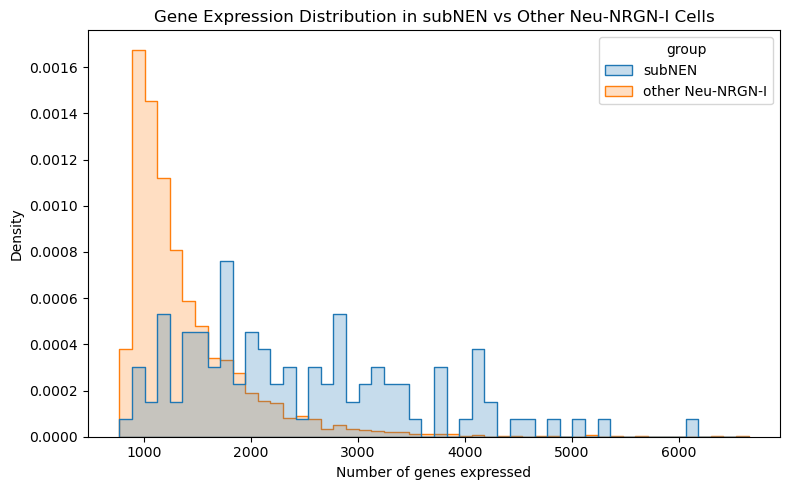

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mark subNEN cells
adata.obs["is_subnen"] = adata.obs_names.isin(subnen_ids)
adata.obs["group"] = adata.obs["is_subnen"].map({True: "subNEN", False: "other Neu-NRGN-I"})

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(data=adata.obs, x="genes", hue="group", bins=50, element="step", stat="density", common_norm=False)
plt.xlabel("Number of genes expressed")
plt.ylabel("Density")
plt.title("Gene Expression Distribution in subNEN vs Other Neu-NRGN-I Cells")
plt.tight_layout()
plt.show()